In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
sns.set_style("whitegrid")

In [2]:
%matplotlib inline

Before we get started on learning about Linear Regression let's load in our ATUS data so we've got a starting point.

In [4]:
summary = pd.read_csv("atussum_2013.dat")
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


Here is a handy function to give us back a `dataFrame` containing ages with mean minutes for any given category.

In [5]:
def activity_by_age(df, activity_code, subsample=True):
    activity_col = "t{}".format(activity_code)
    df = df[['TUFINLWGT', 'TEAGE', activity_col]]
    df = df.rename(columns={"TUFINLWGT": "weight", "TEAGE": "age", activity_col: "minutes"})
    if subsample:
        df = df[df.age % 5 == 0]
    df['weighted_minutes'] = df.weight * df.minutes
    df = df.groupby("age").sum()
    df['mean_minutes'] = df.weighted_minutes / df.weight
    df = df[['mean_minutes']]
    return df

Lets get a `dataFrame` from our summary containing "Medical Care" data.

The code for Medical Care is `080401`.

Also do a scatter plot with the `medical_care.index` as the x, and the `medical_care.mean_minutes` as the y.

<!---
medical_care = activity_by_age(summary, "080401", subsample=False)
plt.scatter(medical_care.index, medical_care.mean_minutes)
--->

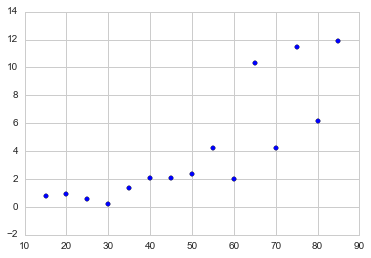

In [8]:
medical_care = activity_by_age(summary, "080401")
plt.scatter(medical_care.index, medical_care.mean_minutes)

## Linear Regression

Linear regression is a way of modeling a relationship between two features in a way that given 2 variables, 1 known, and 1 unknown we can give a close approximation of what our unknown value may equate to.

Or as wikipedia says:
> In linear regression, data are modeled using linear predictor functions, and unknown model parameters are estimated from the data 

Without getting too in depth with how to calculate the predictor function (our line) our goal is going to be to get the minimum (closest to the mean) of our data along an axis.  If our prediction is too aggressive (steep) we will not get an accurate function.  If our prediction is too conservative (shallow) we will also not get an accurate function.  You ultimately want your line to visibly bisect your distribution of data.

The function below will apply a regression function across a dataframe and square the differences in each cell from the mean.  Finally it will divide the sum of differences by 2 times the amount of differences we find.

In [10]:
def linear_least_squares(df, fn):
    values = df.index.map(fn)
    diffs = df.mean_minutes - values
    diffs_squared = diffs ** 2
    return diffs_squared.sum() / (2 * len(diffs)) 

In order to use our `linear_least_squares` function we need to pass it a function.  This function will act as our "line prediction" in which we are attempting to correctly bisect our data.

This is the code to plot a line with a slope of `1/4`:
>`lambda x: 0 + 0.25 * x`

Should I explain linear slope?  Remember - I used to have to calculate roof slope for a living.

Pass the `medical_care` frame to the `linear_least_squares` along with the function above and print your findings.

Also create a scatter plot of your data as well as your regression line prediction.

<!---
fn1 = lambda x: 0 + 0.25 * x
print(linear_least_squares(medical_care, fn1))
plt.scatter(medical_care.index, medical_care.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.array([xmin, xmax])
plt.plot(xs, fn1(xs))
--->

40.5573618265


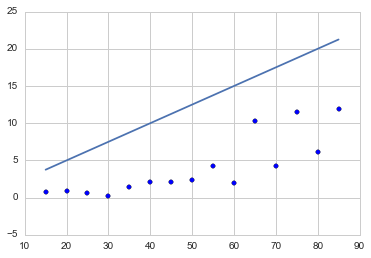

In [18]:
fn1 = lambda x: 0 + 0.25 * x
print(linear_least_squares(medical_care, fn1))

plt.scatter(medical_care.index, medical_care.mean_minutes)
plt.plot(medical_care.index, fn1(medical_care.index))

Try the same but this time with the following linear function:

>`lambda x: 0 + 0.15 * x`

Overlay your original line with an alpha of `0.3`

<!---
fn2 = lambda x: 0 + 0.15 * x
print(linear_least_squares(medical_care, fn2))
plt.scatter(medical_care.index, medical_care.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.array([xmin, xmax])
plt.plot(xs, fn1(xs), alpha=0.3)
plt.plot(xs, fn2(xs))
--->

8.41239858335


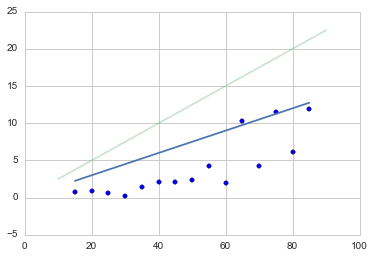

In [26]:
fn2 = lambda x: 0 + 0.15 * x
print(linear_least_squares(medical_care, fn2))

plt.scatter(medical_care.index, medical_care.mean_minutes)
plt.plot(medical_care.index, fn2(medical_care.index))
plt.plot(xs, fn1(xs), alpha=0.3)

Finally lets try with the following function:

>`lambda x: 0 + 0.1 * x`

Overlay previous lines with an alpha of `0.3`

<!---
fn3 = lambda x: 0 + 0.1 * x
print(linear_least_squares(medical_care, fn3))
plt.scatter(medical_care.index, medical_care.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, fn1(xs), alpha=0.3)
plt.plot(xs, fn2(xs), alpha=0.3)
plt.plot(xs, fn3(xs))
--->

3.46491696178
8.41239858335


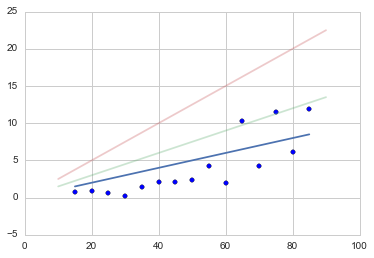

In [27]:
fn3 = lambda x: 0 + 0.1 * x
print(linear_least_squares(medical_care, fn3))
print(linear_least_squares(medical_care, fn2))

plt.scatter(medical_care.index, medical_care.mean_minutes)
plt.plot(medical_care.index, fn3(medical_care.index))
plt.plot(xs, fn2(xs), alpha=0.3)
plt.plot(xs, fn1(xs), alpha=0.3)

57.8416571421
3.46491696178
8.41239858335


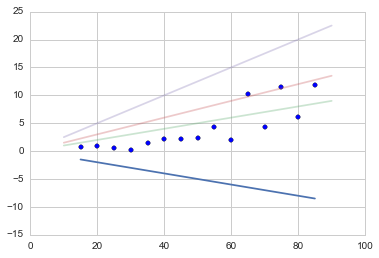

In [28]:
fn4 = lambda x: 0 + -0.1 * x
print(linear_least_squares(medical_care, fn4))

print(linear_least_squares(medical_care, fn3))
print(linear_least_squares(medical_care, fn2))

plt.scatter(medical_care.index, medical_care.mean_minutes)
plt.plot(medical_care.index, fn4(medical_care.index))
plt.plot(xs, fn3(xs), alpha=0.3)

plt.plot(xs, fn2(xs), alpha=0.3)
plt.plot(xs, fn1(xs), alpha=0.3)

Neat! But this isn't really a realistic way to figure out a regression line. Better yet we should use a library to predict our line for us given our data!  We can do this by creating a `LinearRegression()` model and calling it's `fit` method with our data.

<!---
regression = linear_model.LinearRegression()
transposed_index = np.array(medical_care.index.values).reshape((-1, 1))
regression.fit(transposed_index, medical_care.mean_minutes.values)
--->

In [34]:
regression = linear_model.LinearRegression()
transposed_index = np.array(medical_care.index.values).reshape((-1, 1))

regression.fit(transposed_index, medical_care.mean_minutes.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now that we have fit our prediction model to our data lets do cool stuff to it.

In [44]:
regression.predict(60)

array([ 5.53689204])

In [36]:
print(regression.coef_, regression.intercept_)

[ 0.14882703] -3.39272993637


--- define score

In [37]:
regression.score(np.array(medical_care.index.values).reshape((-1, 1)), 
               medical_care.mean_minutes.values)

0.67786204814148743

2.45607150302


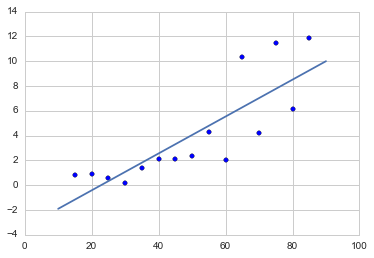

In [40]:
fn = lambda x: regression.predict(x)[0]
print(linear_least_squares(medical_care, fn))
plt.scatter(medical_care.index, medical_care.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, [fn(x) for x in xs])